# 1. Import library

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log

import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import lightgbm as lgb
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import time

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
# Function to perform time convertion 
def tcon(x):
    date, time = x.split(" ")
    hour, minute, second = time.split(":")
    if int(minute) < 15:
        minute = ":00"
    elif int(minute) < 30:
        minute = ":15"
    elif int(minute) < 45:
        minute = ":30"
    else:
        minute = ":45"
    block = date + " " + hour + minute
    return block

In [3]:
# Function to clean the data for bog/n-gram ONLY
def data_cleaning(text):
    token = word_tokenize(text) # tokenize the text into token (1gram- word)
    token = [w.lower() for w in token] # lower the words into lower case
    table = str.maketrans('', '', string.punctuation) # remove punctuation
    stripped = [w.translate(table) for w in token] 
    word = [word for word in token if word.isalpha()] # remove non- alphabetic symbol
    word = [w for w in word if not w in stopword] # remove stop word
    text = "".join([" "+ i for i in word]).strip()
    return text 

In [4]:
#Function to lemmatize the word for bog/n-gram ONLY
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [5]:
# Function to tagging the word
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [6]:
# Function for EDA

def EDA(df):
    print("Sample Mean =", df.Profit.mean(), "\nSample Variance =", df.Profit.var(), "\nSample Adjusted skewness =", df.Profit.skew(), "\nSample Excess Kurtosis =", df.Profit.kurtosis())
    x = df.Profit.quantile([0, 0.25, 0.5,0.75, 1]).values
    print("\nMin =", x[0], "\n1st quartile =", x[1], "\nMedian =", x[2], "\n3rd quartile =", x[3], "\nMax =", x[4])
    sns.displot(df.Profit, bins = 100)
    plt.show()
    text = " ".join(df.News)
    wordcloud = WordCloud(max_words=200).generate(text)
    plt.imshow(wordcloud,interpolation = 'bilinear')
    most_occur = Counter(text.split()).most_common(20)
    print("\n", pd.DataFrame(most_occur, columns = ["word", "frequency"]))

In [7]:
def score(actual, predicted):
    tmp = f1_score(actual, predicted, average = None)
    tmp = tmp[0]+tmp[len(tmp)-1]
    return tmp/2

In [8]:
# Function for showing the out-sample performance
def performance(actual, predicted):
    labels = [0, 1, 2] 
    print(classification_report(actual, predicted, labels)) #classification report from sklearn
    cnf_matrix = confusion_matrix(actual, predicted, labels=labels)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
    threshold = cnf_matrix.max() / 2 #threshold to define text color
    for i in range(cnf_matrix.shape[0]): #print text in grid
        for j in range(cnf_matrix.shape[1]): 
            plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
    tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    return score(actual, predicted)

In [9]:
def d2v(data, model):
    tokenized_doc = []
    
    for d in data.News:
        tokenized_doc.append(word_tokenize(d))
    print("finished word tokenization")
        
    vector = []
    
    for i in tokenized_doc:
        vector.append(model.infer_vector(i))
    print("finished vector representation")
        
    if len(vector) == len(data.News):
        tmp = pd.DataFrame(vector)
        data_tmp = pd.concat([data.reset_index(drop=True), tmp], axis = 1).copy()
        return data_tmp
    else:
        return ("The length of vector dose not matched!")

# Input sp500 data

In [10]:
price_path =                    # URL of price's data

price = pd.read_csv(price_path, sep=';', header = None)
price

,0,1,2,3,4,5,6
0,01/04/2007,17:15:00,1430.00,1431.00,1429.75,1431.00,592
1,01/04/2007,17:30:00,1431.00,1431.50,1430.75,1430.75,461
2,01/04/2007,17:45:00,1430.50,1431.00,1430.25,1430.50,264
3,01/04/2007,18:00:00,1430.50,1430.75,1430.25,1430.75,91
4,01/04/2007,18:15:00,1431.00,1432.00,1431.00,1431.25,561
...,...,...,...,...,...,...,...
322193,07/12/2020,22:45:00,3681.25,3681.50,3680.50,3681.00,787
322194,07/12/2020,23:00:00,3681.25,3682.50,3681.25,3682.25,1179
322195,07/12/2020,23:15:00,3682.25,3683.00,3681.50,3681.50,1087
322196,07/12/2020,23:30:00,3681.75,3682.75,3681.50,3682.00,1291


In [14]:
price.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume" ]

In [15]:
price.Date = price.Date + " " + price.Time 

In [16]:
price

,Date,Time,Open,High,Low,Close,Volume
0,01/04/2007 17:15:00,17:15:00,1430.00,1431.00,1429.75,1431.00,592
1,01/04/2007 17:30:00,17:30:00,1431.00,1431.50,1430.75,1430.75,461
2,01/04/2007 17:45:00,17:45:00,1430.50,1431.00,1430.25,1430.50,264
3,01/04/2007 18:00:00,18:00:00,1430.50,1430.75,1430.25,1430.75,91
4,01/04/2007 18:15:00,18:15:00,1431.00,1432.00,1431.00,1431.25,561
...,...,...,...,...,...,...,...
322193,07/12/2020 22:45:00,22:45:00,3681.25,3681.50,3680.50,3681.00,787
322194,07/12/2020 23:00:00,23:00:00,3681.25,3682.50,3681.25,3682.25,1179
322195,07/12/2020 23:15:00,23:15:00,3682.25,3683.00,3681.50,3681.50,1087
322196,07/12/2020 23:30:00,23:30:00,3681.75,3682.75,3681.50,3682.00,1291


In [17]:
sum(price.Close.isnull())

0

In [18]:
profit = (np.log(price.Close.astype(float)) - np.log(price.Open.astype(float)))*100

In [19]:
price = pd.DataFrame({"timestamp": price.Date, "Profit": profit})

In [20]:
price.timestamp = pd.to_datetime(price.timestamp)

In [21]:
price.timestamp = price.timestamp + timedelta(hours = 1) # change from GMT -6 to GMT -5 

In [22]:
price.shape

(322198, 2)

# Input raw news data

In [23]:
news_path =                           # URL of news data
news = pd.read_csv(news_path, index_col=None, header=0, sep='\t')

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
print(news.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8551425 entries, 0 to 8551424
Data columns (total 5 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   ts        object
 1   title     object
 2   href      object
 3   timezone  object
 4   newts     object
dtypes: object(5)
memory usage: 326.2+ MB
None


In [25]:
news.head()

,ts,title,href,timezone,newts
0,2007-01-01 23:47:00,UPDATE 1-TSMC plans five new advanced wafer pl...,http://www.reuters.com/article/companyNewsAndP...,EST,2007-01-01 22:47:00
1,2007-01-01 23:40:00,U2 roadie gets a moment in the spotlight,http://www.reuters.com/article/musicNews/idUSN...,EST,2007-01-01 22:40:00
2,2007-01-01 23:12:00,Vietnamese family tested negative for bird flu,http://www.reuters.com/article/globalNews/idUS...,EST,2007-01-01 22:12:00
3,2007-01-01 22:58:00,"Chicago jazz mecca closes doors, perhaps forever",http://www.reuters.com/article/musicNews/idUSN...,EST,2007-01-01 21:58:00
4,2007-01-01 22:56:00,"""Factory Girl"" affords more fame to Warhol muse",http://www.reuters.com/article/entertainmentNe...,EST,2007-01-01 21:56:00


In [26]:
news.drop("newts", axis = 1, inplace = True)

In [27]:
news.ts = pd.to_datetime(news.ts)

In [28]:
# convert all timezone to EST
news.loc[news.timezone == "UTC", "timestamp"] = news.loc[news.timezone == "UTC", "ts"] - timedelta(hours = 5)
news.loc[news.timezone == "EDT", "timestamp"] = news.loc[news.timezone == "EDT", "ts"] - timedelta(hours = 1)
news.loc[news.timezone == "EST", "timestamp"] = news.loc[news.timezone == "EST", "ts"] 

In [29]:
news.timestamp = news.timestamp.astype(str)
news.timestamp = news.timestamp.apply(tcon) # convert time into 15 mins interval
news.timestamp = pd.to_datetime(news.timestamp)

In [30]:
news[news['title'].isnull()]

,ts,title,href,timezone,timestamp


In [31]:
news = news[['timestamp','title','href']].drop_duplicates() #drop_duplicates if have duplicates input

In [32]:
news = news[["timestamp","title"]]

In [33]:
news.shape

(8551425, 2)

# Merge 2 dataset

In [34]:
news.timestamp = news.timestamp + timedelta(minutes = 15) # histrorical news to predict future news

In [35]:
print("Earilest news: " , news.timestamp.min() , "\nLatest news: " , news.timestamp.max() , "\n\nEarilest return: " , price.timestamp.min() , "\nLatest return: " , price.timestamp.max()) 

Earilest news:  2007-01-01 01:00:00 
Latest news:  2016-08-16 19:00:00 

Earilest return:  2007-01-04 18:15:00 
Latest return:  2020-12-12 00:45:00


In [36]:
t = pd.DataFrame({"timestamp": pd.date_range('2007-01-01', '2016-08-16', freq='15min')})

In [37]:
t = pd.merge(t, price, on= "timestamp", how = "left")
df = pd.merge(t, news, on= "timestamp", how = "left")

In [38]:
df.timestamp = pd.to_datetime(df.timestamp) 
df.loc[df.title.notnull() == False,"title"] = "Empty"
df["title"] = df.groupby('timestamp')['title'].transform(lambda x: ' '.join(x)) # combine all news released in the same time interval together
df = df[['timestamp','Profit','title']].drop_duplicates()

In [39]:
# to capture time lag, each data row contained 4 set of news repersenting news released before 0-3 x time intervals
df["news2"] = np.append(["EMP"], df.title[0:-1])
df["news3"] = np.append(["EMP"], df.news2[0:-1])
df["news4"] = np.append(["EMP"], df.news3[0:-1])

In [40]:
df = df[df.timestamp >= "2007-01-04 18:15:00"] # filter out the data without stock return
df = df[df.timestamp <= "2016-08-16 18:30:00 "] # filter out the data without news record

In [41]:
df.Profit.isnull().sum()/ len(df.Profit)

0.34301056129108815

In [42]:
df = df[df.Profit.isnull() == False] # Only keep on reliable data

In [43]:
df

,timestamp,Profit,title,news2,news3,news4
1881,2007-01-04 18:15:00,0.069906,UPDATE 1-Power confirms Putnam talks but says ...,"US STOCKS-Indexes end up as Intel lifts techs,...",Former President Bush has second hip replaceme...,Power Financial confirms Putnam talks; no deal...
1888,2007-01-04 18:30:00,-0.017472,Negroponte adds weight to U.S. diplomacy Japan...,UPDATE 1-Power confirms Putnam talks but says ...,"US STOCKS-Indexes end up as Intel lifts techs,...",Former President Bush has second hip replaceme...
1899,2007-01-04 18:45:00,0.000000,Foreign brokers place net Japan stock sell ord...,Negroponte adds weight to U.S. diplomacy Japan...,UPDATE 1-Power confirms Putnam talks but says ...,"US STOCKS-Indexes end up as Intel lifts techs,..."
1908,2007-01-04 19:00:00,0.017475,New U.N. chief speeds plans to reshape bureauc...,Foreign brokers place net Japan stock sell ord...,Negroponte adds weight to U.S. diplomacy Japan...,UPDATE 1-Power confirms Putnam talks but says ...
1926,2007-01-04 19:15:00,0.017469,Longs Drug Stores December same-store US sales...,New U.N. chief speeds plans to reshape bureauc...,Foreign brokers place net Japan stock sell ord...,Negroponte adds weight to U.S. diplomacy Japan...
...,...,...,...,...,...,...
8560455,2016-08-15 23:00:00,0.000000,Column: Who do you hate the least? The dilemma...,BRIEF-Shanghai Shenda cuts share issue size to...,BRIEF-Her Chee Industrial to pay 2015 dividend...,BRIEF-Akis REIT Q2 net result turns to profit ...
8560461,2016-08-15 23:15:00,0.011450,"Shooting: Americans miss the mark, Europeans r...",Column: Who do you hate the least? The dilemma...,BRIEF-Shanghai Shenda cuts share issue size to...,BRIEF-Her Chee Industrial to pay 2015 dividend...
8560477,2016-08-15 23:30:00,0.000000,"BRIEF-Domenomania.pl Q2 net profit up at 39,40...","Shooting: Americans miss the mark, Europeans r...",Column: Who do you hate the least? The dilemma...,BRIEF-Shanghai Shenda cuts share issue size to...
8560495,2016-08-15 23:45:00,0.000000,China Filmâs opening week follows bad IPO sc...,"BRIEF-Domenomania.pl Q2 net profit up at 39,40...","Shooting: Americans miss the mark, Europeans r...",Column: Who do you hate the least? The dilemma...


In [44]:
df['News'] = df[['title', 'news2', 'news3', 'news4']].apply(lambda x: ' '.join(x), axis=1)

In [ ]:
stopword = stopwords.words('english') 
df.News = df.News.apply(data_cleaning) # data cleaning for the our inital model, bag of word with td-idf
df.News = df.News.apply(lemmatize_sentence) # lemmatization for the our inital model, bag of word with td-idf

In [10]:
df.to_csv("processed_df.csv")
# df = pd.read_csv("processed_df.csv", header = 0)
df

,Unnamed: 0,timestamp,Profit,title,news2,news3,news4,News
0,1881,2007-01-04 18:15:00,0.069906,UPDATE 1-Power confirms Putnam talks but says ...,"US STOCKS-Indexes end up as Intel lifts techs,...",Former President Bush has second hip replaceme...,Power Financial confirms Putnam talks; no deal...,update confirms putnam talk say deal yet samsu...
1,1888,2007-01-04 18:30:00,-0.017472,Negroponte adds weight to U.S. diplomacy Japan...,UPDATE 1-Power confirms Putnam talks but says ...,"US STOCKS-Indexes end up as Intel lifts techs,...",Former President Bush has second hip replaceme...,negroponte add weight diplomacy japan toshiba ...
2,1899,2007-01-04 18:45:00,0.000000,Foreign brokers place net Japan stock sell ord...,Negroponte adds weight to U.S. diplomacy Japan...,UPDATE 1-Power confirms Putnam talks but says ...,"US STOCKS-Indexes end up as Intel lifts techs,...",foreign broker place net japan stock sell orde...
3,1908,2007-01-04 19:00:00,0.017475,New U.N. chief speeds plans to reshape bureauc...,Foreign brokers place net Japan stock sell ord...,Negroponte adds weight to U.S. diplomacy Japan...,UPDATE 1-Power confirms Putnam talks but says ...,new chief speed plan reshape bureaucracy updat...
4,1926,2007-01-04 19:15:00,0.017469,Longs Drug Stores December same-store US sales...,New U.N. chief speeds plans to reshape bureauc...,Foreign brokers place net Japan stock sell ord...,Negroponte adds weight to U.S. diplomacy Japan...,longs drug store december us sale pct liberty ...
...,...,...,...,...,...,...,...,...
221453,8560455,2016-08-15 23:00:00,0.000000,Column: Who do you hate the least? The dilemma...,BRIEF-Shanghai Shenda cuts share issue size to...,BRIEF-Her Chee Industrial to pay 2015 dividend...,BRIEF-Akis REIT Q2 net result turns to profit ...,column hate least dilemma french voter comment...
221454,8560461,2016-08-15 23:15:00,0.011450,"Shooting: Americans miss the mark, Europeans r...",Column: Who do you hate the least? The dilemma...,BRIEF-Shanghai Shenda cuts share issue size to...,BRIEF-Her Chee Industrial to pay 2015 dividend...,shoot american miss mark european rule range m...
221455,8560477,2016-08-15 23:30:00,0.000000,"BRIEF-Domenomania.pl Q2 net profit up at 39,40...","Shooting: Americans miss the mark, Europeans r...",Column: Who do you hate the least? The dilemma...,BRIEF-Shanghai Shenda cuts share issue size to...,net profit zloty technology pay dividend europ...
221456,8560495,2016-08-15 23:45:00,0.000000,China Filmâs opening week follows bad IPO sc...,"BRIEF-Domenomania.pl Q2 net profit up at 39,40...","Shooting: Americans miss the mark, Europeans r...",Column: Who do you hate the least? The dilemma...,china open week follow bad ipo script forbes s...


In [11]:
df = df[["timestamp", "Profit", "News"]]
df.reset_index(drop = True, inplace = True) #reset index
df["News"][6894] # example

'nz win america cup classic go earnings calendar transportation acquire marine transportation operation hawaii seattle approx mln conference meeting interest subprime crisis open banker broker rift update energy amends ferc complaint ecuador shelf oilfield drilling plan year sec cox say agency probe cdo matter live earth global warming gig ditch istanbul italy antitrust body probe bank insurer link uae bank company offer buy egyptian bank uk meet office see wet warm north europe summer bid pdvsa borco oil storage see mln stock bond low bond watch wind low mauresmo unruffled henman cause buzz abbas seek bolster fatah force declare ecuador galapagos island danger brixton warns oversold property fund backlash stock market update tue jun edt jones lang chief see peak reit buyout health problem follow childhood cancer survivor abbas seek bolster fatah force abbas seek bolster fatah force credit suisse see property stock weakness correct us drop subprime worry weigh mexico stock mortage mark

In [12]:
len(df[df.timestamp >= "2014-10-01 00:00:00"])

44064

In [13]:
len(df[(df.timestamp >= "2012-11-01 00:00:00") &(df.timestamp < "2014-10-01 00:00:00") ])

44909

In [14]:
# training-validation-testing approach
train = df[df.timestamp < "2012-11-01 00:00:00"]
validation = df[(df.timestamp >= "2012-11-01 00:00:00") &(df.timestamp < "2014-10-01 00:00:00")]
test = df[df.timestamp >= "2014-10-01 00:00:00"]

In [15]:
train.shape

(132485, 3)

In [16]:
df

,timestamp,Profit,News
0,2007-01-04 18:15:00,0.069906,update confirms putnam talk say deal yet samsu...
1,2007-01-04 18:30:00,-0.017472,negroponte add weight diplomacy japan toshiba ...
2,2007-01-04 18:45:00,0.000000,foreign broker place net japan stock sell orde...
3,2007-01-04 19:00:00,0.017475,new chief speed plan reshape bureaucracy updat...
4,2007-01-04 19:15:00,0.017469,longs drug store december us sale pct liberty ...
...,...,...,...
221453,2016-08-15 23:00:00,0.000000,column hate least dilemma french voter comment...
221454,2016-08-15 23:15:00,0.011450,shoot american miss mark european rule range m...
221455,2016-08-15 23:30:00,0.000000,net profit zloty technology pay dividend europ...
221456,2016-08-15 23:45:00,0.000000,china open week follow bad ipo script forbes s...


# EDA

Sample Mean = -6.605503610663323e-05 
Sample Variance = 0.025614317235473666 
Sample Adjusted skewness = -0.04840927209799198 
Sample Excess Kurtosis = 43.31309595035078

Min = -4.438087158931836 
1st quartile = -0.04976362381876598 
Median = 0.0 
3rd quartile = 0.05249803252951324 
Max = 3.6116860470500884


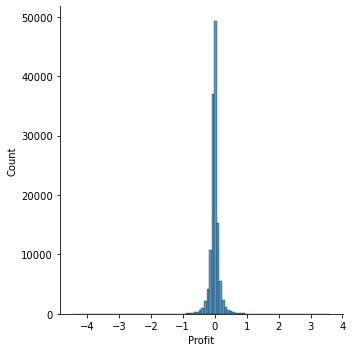


           word  frequency
0          reg    1686331
1        asset    1586048
2          net    1562834
3        value    1519447
4          new    1052263
5       update     995953
6          plc     976335
7    announces     958240
8       result     844553
9       market     838001
10      report     764770
11       group     664603
12     quarter     659466
13         etf     537708
14       share     502814
15    research     465260
16  conference     461436
17        bank     448183
18     company     437692
19   financial     424150


In [ ]:
EDA(train)

In [15]:
BUY = train[train.Profit >= 0.05] 
HOLD = train[(train.Profit > -0.05) & (train.Profit < 0.05)] 
SELL = train[train.Profit <= -0.05] 

Sample Mean = 0.15783846372142474 
Sample Variance = 0.02499943094768623 
Sample Adjusted skewness = 5.615834897594974 
Sample Excess Kurtosis = 59.62233185325014

Min = 0.05249803252951324 
1st quartile = 0.07411525260518914 
Median = 0.11109055021396587 
3rd quartile = 0.17956549985598258 
Max = 3.6116860470500884


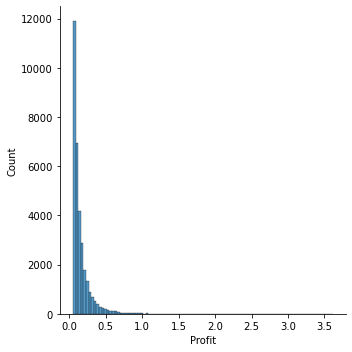


           word  frequency
0        asset     370822
1          net     364114
2          reg     358139
3        value     352870
4          new     305193
5    announces     285929
6       update     277515
7          plc     244872
8       market     230806
9       result     228393
10      report     217084
11     quarter     196761
12       group     168700
13  conference     139701
14       share     134151
15    research     131416
16     company     125764
17        bank     125734
18   financial     123960
19         etf     123119


In [ ]:
EDA(BUY)

Sample Mean = -0.15957587321767755 
Sample Variance = 0.025703200714131506 
Sample Adjusted skewness = -5.43969316654499 
Sample Excess Kurtosis = 65.35257652402365

Min = -4.438087158931836 
1st quartile = -0.18482395650458727 
Median = -0.10970928143727576 
3rd quartile = -0.07195539076425561 
Max = -0.04976362381876598


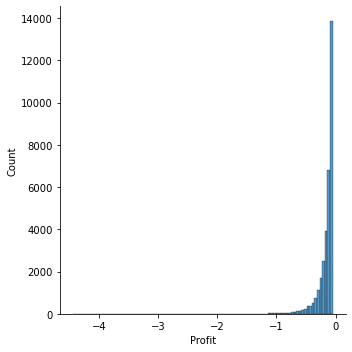


           word  frequency
0        asset     363293
1          net     356667
2          reg     347113
3        value     345414
4          new     303942
5    announces     282157
6       update     275376
7          plc     240951
8       market     228149
9       result     226430
10      report     213882
11     quarter     191400
12       group     170149
13  conference     136898
14       share     134137
15    research     129378
16        bank     124614
17     company     124246
18         etf     122451
19   financial     121574


In [ ]:
EDA(SELL)

In [17]:
train.loc[(train.Profit >= 0.05), "Strategy"] = 0
train.loc[((train.Profit > -0.05) & (train.Profit < 0.05)), "Strategy"] = 1
train.loc[(train.Profit <= -0.05), "Strategy"] = 2 

validation.loc[(validation.Profit >= 0.05), "Strategy"] = 0
validation.loc[((validation.Profit > -0.05) & (validation.Profit < 0.05)), "Strategy"] = 1
validation.loc[(validation.Profit <= -0.05), "Strategy"] = 2

test.loc[(test.Profit >= 0.05), "Strategy"] = 0
test.loc[((test.Profit > -0.05) & (test.Profit < 0.05)), "Strategy"] = 1
test.loc[(test.Profit <= -0.05), "Strategy"] = 2 

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [18]:
train.Strategy = train.Strategy.astype("category")
validation.Strategy = validation.Strategy.astype("category")
test.Strategy = test.Strategy.astype("category")

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
train.Strategy

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0         0.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
132480    1.0
132481    0.0
132482    1.0
132483    2.0
132484    1.0
Name: Strategy, Length: 132485, dtype: category
Categories (3, float64): [0.0, 1.0, 2.0]

# Feature Engineering - BOG with Tf-idf

In [19]:
basicvectorizer = TfidfVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(train.News)
basictest = basicvectorizer.transform(test.News)
basicvalidation = basicvectorizer.transform(validation.News)

In [20]:
mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 2046, n_jobs = -1)
fit1 = mod1.fit(basictrain, train.Strategy)

In [21]:
pred1_train = fit1.predict(basictrain)
pred1 = fit1.predict(basicvalidation)
pred1_test = fit1.predict(basictest)

              precision    recall  f1-score   support

           0       0.54      0.55      0.54     33891
           1       0.70      0.67      0.68     65551
           2       0.54      0.57      0.55     33043

    accuracy                           0.61    132485
   macro avg       0.59      0.60      0.59    132485
weighted avg       0.62      0.61      0.61    132485



0.5479721921588339

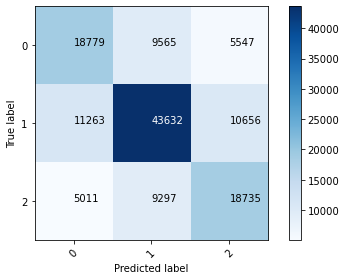

In [25]:
performance(train.Strategy, pred1_train)

              precision    recall  f1-score   support

           0       0.21      0.40      0.27      7173
           1       0.78      0.53      0.63     31106
           2       0.18      0.26      0.21      6630

    accuracy                           0.47     44909
   macro avg       0.39      0.40      0.37     44909
weighted avg       0.60      0.47      0.51     44909



0.24342948245696858

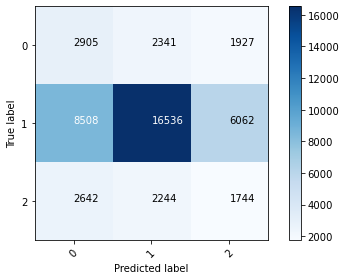

In [26]:
performance(validation.Strategy, pred1)

              precision    recall  f1-score   support

           0       0.23      0.24      0.23      8287
           1       0.67      0.68      0.68     27696
           2       0.22      0.20      0.21      8081

    accuracy                           0.51     44064
   macro avg       0.37      0.37      0.37     44064
weighted avg       0.50      0.51      0.51     44064



0.219972907631642

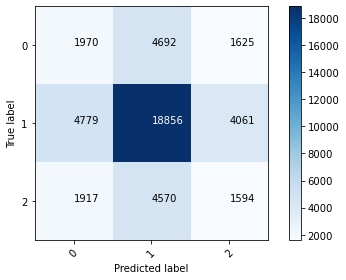

In [27]:
performance(test.Strategy, pred1_test)

In [74]:
mod1words = basicvectorizer.get_feature_names()
fi = fit1.feature_importances_
fidf = pd.DataFrame({'Words' : mod1words, 
                        'Feature Importance' : fi})

fidf = fidf.sort_values(['Feature Importance', 'Words'], ascending=[0, 1])
fidf.head(20)

,Words,Feature Importance
214708,reg,65
45878,china,63
57668,crisis,43
92764,follow,40
182847,obama,35
131520,jgbs,30
166482,mln,29
126749,investec,27
11976,announces,26
130451,japan,26


In [75]:
print(basictrain.shape)
print(sum(np.array(fit1.feature_importances_) == 0 ))

(132485, 292493)
288400


# Dimension reduction by limiting max and min td-idf

In [19]:
# A gird search is performed to find the best min_df and max_df assuming no change on other hyperparameter of lightGBM yet.
mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 2046, n_jobs = -1)

min_df = [0, 0.01, 0.02, 0.03, 0.04]
max_df = [0.8, 0.85, 0.9, 0.95, 1]

val_score = np.zeros((len(min_df), len(max_df)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        if max_df[j] == 1:
            basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i])
        else:
            basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.News)
        basicvalidation = basicvectorizer.transform(validation.News)
        
        fit1 = mod1.fit(basictrain, train.Strategy)
        pred1 = fit1.predict(basicvalidation)
        val_score[i,j] = score(validation.Strategy, pred1)
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])

Finished the model with min_df = 0 and max_df =  0.8
Finished the model with min_df = 0 and max_df =  0.85
Finished the model with min_df = 0 and max_df =  0.9
Finished the model with min_df = 0 and max_df =  0.95
Finished the model with min_df = 0 and max_df =  1
Finished the model with min_df = 0.01 and max_df =  0.8
Finished the model with min_df = 0.01 and max_df =  0.85
Finished the model with min_df = 0.01 and max_df =  0.9
Finished the model with min_df = 0.01 and max_df =  0.95
Finished the model with min_df = 0.01 and max_df =  1
Finished the model with min_df = 0.02 and max_df =  0.8
Finished the model with min_df = 0.02 and max_df =  0.85
Finished the model with min_df = 0.02 and max_df =  0.9
Finished the model with min_df = 0.02 and max_df =  0.95
Finished the model with min_df = 0.02 and max_df =  1
Finished the model with min_df = 0.03 and max_df =  0.8
Finished the model with min_df = 0.03 and max_df =  0.85
Finished the model with min_df = 0.03 and max_df =  0.9
Finish

In [20]:
val_score.max(axis=1)

array([0.24383825, 0.24638997, 0.24728652, 0.2461469 , 0.2428661 ])

In [21]:
val_score.max(axis=0)

array([0.24716638, 0.24728652, 0.24638997, 0.24638997, 0.24638997])

In [22]:
val_score[2, 1]

0.24728652498425713

min_df = 0.02
max_df = 0.85

In [19]:
basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 0.02, max_df = 0.85)
basictrain = basicvectorizer.fit_transform(train.News)
basicvalidation = basicvectorizer.transform(validation.News)
basictest = basicvectorizer.transform(test.News)

# Gird Search 

objective = 'multiclass'

class_weight = "balanced"

learning_rate = 0.1

min_df = 0.02

max_df = 0.85

n_estimators = 

max_depth = 

colsample_bytree = 

reg_alpha = 

reg_lambda = 

In [20]:
n_estimators = [10, 30, 50, 100, 150, 200]

val_score = np.zeros((len(n_estimators)))

for i in range(len(n_estimators)):
    start_time = time.time()
    mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                         learning_rate = 0.1, n_estimators = n_estimators[i])
    fit1 = mod1.fit(basictrain, train.Strategy)
    pred1 = fit1.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred1)
    
    print("Finished the model with n_estimators =", n_estimators[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with n_estimators = 10
--- 26.871601819992065 seconds ---
Finished the model with n_estimators = 30
--- 50.492982149124146 seconds ---
Finished the model with n_estimators = 50
--- 70.56165099143982 seconds ---
Finished the model with n_estimators = 100
--- 105.02547812461853 seconds ---
Finished the model with n_estimators = 150
--- 136.00914788246155 seconds ---
Finished the model with n_estimators = 200
--- 165.99635195732117 seconds ---


In [21]:
val_score

array([0.24164576, 0.24356832, 0.24443593, 0.24728652, 0.24538948,
       0.24416201])

In [22]:
val_score[3]

0.24728652498425713

In [26]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

val_score = np.zeros((len(max_depth)))

for i in range(len(max_depth)):
    start_time = time.time()
    mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                         learning_rate = 0.1, n_estimators = 100, max_depth = max_depth[i], num_leaves = 2**max_depth[i]+1)
    fit1 = mod1.fit(basictrain, train.Strategy)
    pred1 = fit1.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred1)
    
    print("Finished the model with max_depth =", max_depth[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with max_depth = 1
--- 44.48656368255615 seconds ---
Finished the model with max_depth = 2
--- 52.9736750125885 seconds ---
Finished the model with max_depth = 3
--- 60.172322034835815 seconds ---
Finished the model with max_depth = 4
--- 68.90432095527649 seconds ---
Finished the model with max_depth = 5
--- 78.85705184936523 seconds ---
Finished the model with max_depth = 6
--- 90.81422400474548 seconds ---
Finished the model with max_depth = 7
--- 105.76493906974792 seconds ---
Finished the model with max_depth = 8
--- 125.13331723213196 seconds ---
Finished the model with max_depth = 9
--- 146.96611499786377 seconds ---
Finished the model with max_depth = 10
--- 213.18199801445007 seconds ---


In [27]:
val_score

array([0.23467666, 0.23171332, 0.23857736, 0.24210893, 0.24322026,
       0.24533902, 0.24677182, 0.24253333, 0.23870384, 0.24016146])

In [28]:
val_score[6]

0.24677182446577456

In [30]:
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]

val_score = np.zeros(len(colsample_bytree))

for i in range(len(colsample_bytree)):
    start_time = time.time()
    mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 7, num_leaves = 129, 
                        colsample_bytree = colsample_bytree[i])
    fit1 = mod1.fit(basictrain, train.Strategy)
    fit1 = mod1.fit(basictrain, train.Strategy)
    pred1 = fit1.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred1)
    
    print("Finished the model with colsample_bytree =", colsample_bytree[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with colsample_bytree = 0.1
--- 84.28679013252258 seconds ---
Finished the model with colsample_bytree = 0.2
--- 111.54145789146423 seconds ---
Finished the model with colsample_bytree = 0.3
--- 141.03445291519165 seconds ---
Finished the model with colsample_bytree = 0.4
--- 168.35745477676392 seconds ---
Finished the model with colsample_bytree = 0.5
--- 191.37067127227783 seconds ---
Finished the model with colsample_bytree = 0.6
--- 201.22482800483704 seconds ---
Finished the model with colsample_bytree = 0.7
--- 184.98922395706177 seconds ---
Finished the model with colsample_bytree = 0.8
--- 190.07721090316772 seconds ---
Finished the model with colsample_bytree = 0.9
--- 191.4558720588684 seconds ---
Finished the model with colsample_bytree = 1
--- 194.02742886543274 seconds ---


In [31]:
val_score

array([0.24193178, 0.24544116, 0.24481686, 0.24426364, 0.24201208,
       0.24322468, 0.24480811, 0.24823913, 0.25091512, 0.24677182])

In [32]:
reg_alpha = [0, 1, 2,3,4,5]
reg_lambda = [0, 1, 2,3,4,5]

val_score = np.zeros((len(reg_alpha), len(reg_lambda)))

for i in range(len(reg_alpha)):
    for j in range(len(reg_lambda)):
        start_time = time.time()
        mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = reg_alpha[i], reg_lambda = reg_lambda[j])
        fit1 = mod1.fit(basictrain, train.Strategy)
        pred1 = fit1.predict(basicvalidation)
        val_score[i,j] = score(validation.Strategy, pred1)
    
        print("Finished the model with reg_alpha =", reg_alpha[i], "and reg_lambda =", reg_lambda[j])
        print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with reg_alpha = 0 and reg_lambda = 0
--- 97.59093308448792 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 1
--- 103.2830798625946 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 2
--- 100.78897404670715 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 3
--- 105.84365367889404 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 4
--- 103.55224609375 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 5
--- 103.04143714904785 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 0
--- 108.25446486473083 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 1
--- 109.20595717430115 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 2
--- 113.45925092697144 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 3
--- 111.45858907699585 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 4
--- 111.08317995071411 secon

In [33]:
val_score.max()

0.25091511725024623

In [34]:
val_score.max(axis =1)

array([0.25091512, 0.24670921, 0.2454149 , 0.24691761, 0.24784352,
       0.24413511])

In [35]:
val_score.max(axis =0)

array([0.25091512, 0.24511502, 0.24524746, 0.24866457, 0.24605379,
       0.24784352])

In [36]:
val_score[0, 0]

0.25091511725024623

In [19]:
mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)

min_df = [0.01, 0.02, 0.03, 0.04]
max_df = [0.8, 0.85, 0.9, 0.95, 1]

val_score = np.zeros((len(min_df), len(max_df)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        if max_df[j] == 1:
            basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i])
        else:
            basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.News)
        basicvalidation = basicvectorizer.transform(validation.News)
        
        fit1 = mod1.fit(basictrain, train.Strategy)
        pred1 = fit1.predict(basicvalidation)
        val_score[i,j] = score(validation.Strategy, pred1)
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])

Finished the model with min_df = 0.01 and max_df =  0.8
Finished the model with min_df = 0.01 and max_df =  0.85
Finished the model with min_df = 0.01 and max_df =  0.9
Finished the model with min_df = 0.01 and max_df =  0.95
Finished the model with min_df = 0.01 and max_df =  1
Finished the model with min_df = 0.02 and max_df =  0.8
Finished the model with min_df = 0.02 and max_df =  0.85
Finished the model with min_df = 0.02 and max_df =  0.9
Finished the model with min_df = 0.02 and max_df =  0.95
Finished the model with min_df = 0.02 and max_df =  1
Finished the model with min_df = 0.03 and max_df =  0.8
Finished the model with min_df = 0.03 and max_df =  0.85
Finished the model with min_df = 0.03 and max_df =  0.9
Finished the model with min_df = 0.03 and max_df =  0.95
Finished the model with min_df = 0.03 and max_df =  1
Finished the model with min_df = 0.04 and max_df =  0.8
Finished the model with min_df = 0.04 and max_df =  0.85
Finished the model with min_df = 0.04 and max_d

In [21]:
val_score.max(axis = 1)

array([0.24473408, 0.25091512, 0.24381912, 0.24341778])

In [22]:
val_score.max(axis = 0)

array([0.24473408, 0.25091512, 0.2434385 , 0.2434385 , 0.2434385 ])

In [23]:
basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 0.02, max_df = 0.85)
basictrain = basicvectorizer.fit_transform(train.News)
basicvalidation = basicvectorizer.transform(validation.News)
basictest = basicvectorizer.transform(test.News)

In [26]:
n_estimators = [10, 30, 50, 100, 150, 200, 300]

val_score = np.zeros((len(n_estimators)))

for i in range(len(n_estimators)):
    start_time = time.time()
    mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = n_estimators[i], max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)
    fit1 = mod1.fit(basictrain, train.Strategy)
    pred1 = fit1.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred1)
    
    print("Finished the model with n_estimators =", n_estimators[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with n_estimators = 10
--- 30.039335012435913 seconds ---
Finished the model with n_estimators = 30
--- 52.75768995285034 seconds ---
Finished the model with n_estimators = 50
--- 74.7722008228302 seconds ---
Finished the model with n_estimators = 100
--- 105.19764423370361 seconds ---
Finished the model with n_estimators = 150
--- 131.8245210647583 seconds ---
Finished the model with n_estimators = 200
--- 160.7210750579834 seconds ---
Finished the model with n_estimators = 300
--- 219.15481400489807 seconds ---


In [27]:
val_score

array([0.2372081 , 0.24573854, 0.24706324, 0.25091512, 0.24540242,
       0.24284507, 0.24131739])

# Finalised 1-gram model

In [41]:
basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 0.02, max_df = 0.85)
basictrain = basicvectorizer.fit_transform(train.News)
basicvalidation = basicvectorizer.transform(validation.News)
basictest = basicvectorizer.transform(test.News)

mod1 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)
fit1 = mod1.fit(basictrain, train.Strategy)
pred1_train = fit1.predict(basictrain)
pred1 = fit1.predict(basicvalidation)
pred1_test = fit1.predict(basictest)

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

           0       0.60      0.62      0.61     33891
           1       0.72      0.70      0.71     65551
           2       0.61      0.62      0.61     33043

    accuracy                           0.66    132485
   macro avg       0.64      0.65      0.65    132485
weighted avg       0.66      0.66      0.66    132485



0.612330580822817

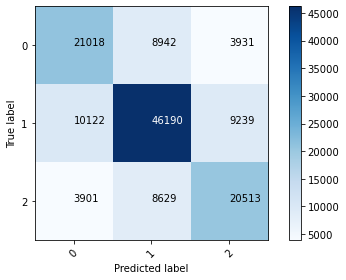

In [42]:
performance(train.Strategy, pred1_train)

              precision    recall  f1-score   support

           0       0.21      0.40      0.28      7173
           1       0.78      0.53      0.63     31106
           2       0.19      0.29      0.22      6630

    accuracy                           0.47     44909
   macro avg       0.39      0.41      0.38     44909
weighted avg       0.60      0.47      0.51     44909



0.25091511725024623

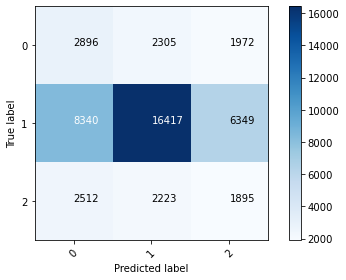

In [43]:
performance(validation.Strategy, pred1)

              precision    recall  f1-score   support

           0       0.23      0.24      0.23      8287
           1       0.67      0.68      0.68     27696
           2       0.22      0.20      0.21      8081

    accuracy                           0.51     44064
   macro avg       0.37      0.37      0.37     44064
weighted avg       0.51      0.51      0.51     44064



0.22131675759576336

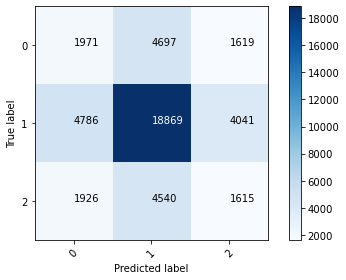

In [44]:
performance(test.Strategy, pred1_test)

In [45]:
mod1words = basicvectorizer.get_feature_names()
fi = fit1.feature_importances_
fidf = pd.DataFrame({'Words' : mod1words, 
                        'Feature Importance' : fi})

fidf = fidf.sort_values(['Feature Importance', 'Words'], ascending=[0, 1])
fidf.head(20)

,Words,Feature Importance
1529,follow,117
667,china,115
3186,release,96
3166,reg,82
3844,test,82
4037,us,74
3376,say,72
1430,fall,70
2474,mln,68
176,announces,67


# 2-grams model

In [46]:
basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = 0.02, max_df = 0.85)
basictrain = basicvectorizer.fit_transform(train.News)
basictest = basicvectorizer.transform(test.News)
basicvalidation = basicvectorizer.transform(validation.News)

In [47]:
mod2 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)
fit2 = mod2.fit(basictrain, train.Strategy)

In [48]:
pred2_train = fit2.predict(basictrain)
pred2 = fit2.predict(basicvalidation)
pred2_test = fit2.predict(basictest)

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

           0       0.50      0.51      0.51     33891
           1       0.67      0.69      0.68     65551
           2       0.53      0.48      0.50     33043

    accuracy                           0.59    132485
   macro avg       0.56      0.56      0.56    132485
weighted avg       0.59      0.59      0.59    132485



0.5038060433789409

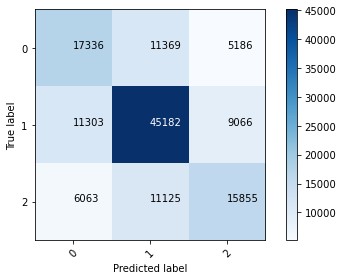

In [49]:
performance(train.Strategy, pred2_train)

              precision    recall  f1-score   support

           0       0.20      0.40      0.27      7173
           1       0.77      0.56      0.65     31106
           2       0.19      0.24      0.21      6630

    accuracy                           0.49     44909
   macro avg       0.39      0.40      0.38     44909
weighted avg       0.60      0.49      0.53     44909



0.24068428109115494

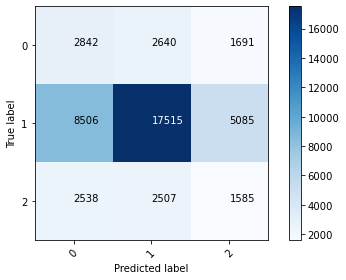

In [50]:
performance(validation.Strategy, pred2)

              precision    recall  f1-score   support

           0       0.22      0.24      0.23      8287
           1       0.66      0.69      0.67     27696
           2       0.21      0.16      0.18      8081

    accuracy                           0.51     44064
   macro avg       0.36      0.36      0.36     44064
weighted avg       0.49      0.51      0.50     44064



0.2050623938724242

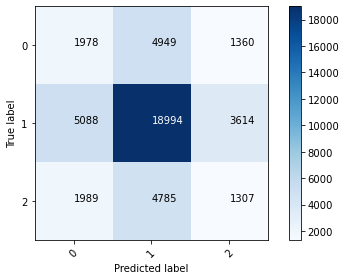

In [51]:
performance(test.Strategy, pred2_test)

max_df, min_df turning

In [19]:
mod3 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)

min_df = [0.01, 0.02, 0.03, 0.04]
max_df = [0.4, 0.6, 0.8, 1]

val_score = np.zeros((len(min_df), len(max_df)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        if max_df[j] == 1:
            basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = min_df[i])
        else:
            basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.News)
        basicvalidation = basicvectorizer.transform(validation.News)
        
        fit2 = mod2.fit(basictrain, train.Strategy)
        pred2 = fit2.predict(basicvalidation)
        val_score[i,j] = score(validation.Strategy, pred2)
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])

Finished the model with min_df = 0.01 and max_df =  0.4
Finished the model with min_df = 0.01 and max_df =  0.6
Finished the model with min_df = 0.01 and max_df =  0.8
Finished the model with min_df = 0.01 and max_df =  1
Finished the model with min_df = 0.02 and max_df =  0.4
Finished the model with min_df = 0.02 and max_df =  0.6
Finished the model with min_df = 0.02 and max_df =  0.8
Finished the model with min_df = 0.02 and max_df =  1
Finished the model with min_df = 0.03 and max_df =  0.4
Finished the model with min_df = 0.03 and max_df =  0.6
Finished the model with min_df = 0.03 and max_df =  0.8
Finished the model with min_df = 0.03 and max_df =  1
Finished the model with min_df = 0.04 and max_df =  0.4
Finished the model with min_df = 0.04 and max_df =  0.6
Finished the model with min_df = 0.04 and max_df =  0.8
Finished the model with min_df = 0.04 and max_df =  1


In [21]:
val_score.max(axis = 1)

array([0.24064329, 0.24291495, 0.23954276, 0.24237584])

In [23]:
val_score.max(axis = 0)

array([0.24291495, 0.24068428, 0.24068428, 0.24068428])

In [20]:
basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = 0.02, max_df = 0.4)
basictrain = basicvectorizer.fit_transform(train.News)
basicvalidation = basicvectorizer.transform(validation.News)
basictest = basicvectorizer.transform(test.News)

In [25]:
n_estimators = [10, 30, 50, 100, 150, 200, 300]

val_score = np.zeros((len(n_estimators)))

for i in range(len(n_estimators)):
    start_time = time.time()
    mod2 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = n_estimators[i], max_depth = 7, num_leaves = 129, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)
    fit2 = mod2.fit(basictrain, train.Strategy)
    pred2 = fit2.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred2)
    
    print("Finished the model with n_estimators =", n_estimators[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with n_estimators = 10
--- 8.943965911865234 seconds ---
Finished the model with n_estimators = 30
--- 12.18501615524292 seconds ---
Finished the model with n_estimators = 50
--- 16.660294771194458 seconds ---
Finished the model with n_estimators = 100
--- 27.078731060028076 seconds ---
Finished the model with n_estimators = 150
--- 32.986790895462036 seconds ---
Finished the model with n_estimators = 200
--- 41.147154092788696 seconds ---
Finished the model with n_estimators = 300
--- 56.387068033218384 seconds ---


In [26]:
val_score

array([0.23451915, 0.24156449, 0.24138139, 0.24291495, 0.24259572,
       0.24102799, 0.23725147])

In [27]:
val_score[3]

0.2429149520558973

In [28]:
max_depth = [1,2,3,4,5,6,7,8,9,10]

val_score = np.zeros((len(max_depth)))

for i in range(len(max_depth)):
    start_time = time.time()
    mod2 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = max_depth[i], num_leaves = 2**max_depth[i]+1, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 0)
    fit2 = mod2.fit(basictrain, train.Strategy)
    pred2 = fit2.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred2)

    print("Finished the model with max_depth =", max_depth[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with max_depth = 1
--- 11.769036054611206 seconds ---
Finished the model with max_depth = 2
--- 12.4336838722229 seconds ---
Finished the model with max_depth = 3
--- 14.155574083328247 seconds ---
Finished the model with max_depth = 4
--- 16.001200914382935 seconds ---
Finished the model with max_depth = 5
--- 17.936711072921753 seconds ---
Finished the model with max_depth = 6
--- 20.497804164886475 seconds ---
Finished the model with max_depth = 7
--- 24.307456970214844 seconds ---
Finished the model with max_depth = 8
--- 28.879267930984497 seconds ---
Finished the model with max_depth = 9
--- 34.667495250701904 seconds ---
Finished the model with max_depth = 10
--- 43.671287059783936 seconds ---


In [29]:
val_score

array([0.21718587, 0.2218858 , 0.23070896, 0.23662945, 0.23645607,
       0.23759007, 0.24291495, 0.24162946, 0.24412608, 0.23895561])

In [30]:
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]

val_score = np.zeros(len(colsample_bytree))

for i in range(len(colsample_bytree)):
    start_time = time.time()
    mod2 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 9, num_leaves = 2**9+1, 
                        colsample_bytree = colsample_bytree[i], reg_alpha = 0, reg_lambda = 0)
    fit2 = mod2.fit(basictrain, train.Strategy)
    fit2 = mod2.fit(basictrain, train.Strategy)
    pred2 = fit2.predict(basicvalidation)
    val_score[i] = score(validation.Strategy, pred2)
    
    print("Finished the model with colsample_bytree =", colsample_bytree[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with colsample_bytree = 0.1
--- 35.677937030792236 seconds ---
Finished the model with colsample_bytree = 0.2
--- 46.55678391456604 seconds ---
Finished the model with colsample_bytree = 0.3
--- 56.36997389793396 seconds ---
Finished the model with colsample_bytree = 0.4
--- 65.19521880149841 seconds ---
Finished the model with colsample_bytree = 0.5
--- 75.30300188064575 seconds ---
Finished the model with colsample_bytree = 0.6
--- 74.24315404891968 seconds ---
Finished the model with colsample_bytree = 0.7
--- 65.0988130569458 seconds ---
Finished the model with colsample_bytree = 0.8
--- 66.03393030166626 seconds ---
Finished the model with colsample_bytree = 0.9
--- 67.77288699150085 seconds ---
Finished the model with colsample_bytree = 1
--- 69.16404986381531 seconds ---


In [32]:
val_score.max()

0.2441260791572504

In [33]:
val_score.argmax()

8

In [36]:
reg_alpha = [0, 1, 2,3,4,5]
reg_lambda = [0, 1, 2,3,4,5]

val_score = np.zeros((len(reg_alpha), len(reg_lambda)))

for i in range(len(reg_alpha)):
    for j in range(len(reg_lambda)):
        start_time = time.time()
        mod2 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 9, num_leaves = 2**9+1, 
                        colsample_bytree = 0.9, reg_alpha = reg_alpha[i], reg_lambda = reg_lambda[j])
        fit2 = mod2.fit(basictrain, train.Strategy)
        fit2 = mod2.fit(basictrain, train.Strategy)
        pred2 = fit2.predict(basicvalidation)
        val_score[i,j] = score(validation.Strategy, pred2)
    
        print("Finished the model with reg_alpha =", reg_alpha[i], "and reg_lambda =", reg_lambda[j])
        print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with reg_alpha = 0 and reg_lambda = 0
--- 64.86676383018494 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 1
--- 68.39655685424805 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 2
--- 68.67139196395874 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 3
--- 67.93736910820007 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 4
--- 68.23092317581177 seconds ---
Finished the model with reg_alpha = 0 and reg_lambda = 5
--- 69.43372297286987 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 0
--- 73.55054998397827 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 1
--- 73.64712309837341 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 2
--- 74.11304092407227 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 3
--- 74.2677960395813 seconds ---
Finished the model with reg_alpha = 1 and reg_lambda = 4
--- 75.1329071521759 seconds ---
F

In [38]:
val_score.max(axis = 1)

array([0.24859539, 0.24367023, 0.24531334, 0.24676999, 0.24206932,
       0.24325296])

In [39]:
val_score.max(axis = 0)

array([0.24412608, 0.24385943, 0.24621335, 0.2429486 , 0.24859539,
       0.24676999])

# Finalised 2-gram model

In [21]:
mod2 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 9, num_leaves = 2**9+1, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 4)

In [22]:
fit2 = mod2.fit(basictrain, train.Strategy)
pred2_train = fit2.predict(basictrain)
pred2 = fit2.predict(basicvalidation)
pred2_test = fit2.predict(basictest)

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

           0       0.56      0.56      0.56     33891
           1       0.69      0.71      0.70     65551
           2       0.58      0.55      0.57     33043

    accuracy                           0.63    132485
   macro avg       0.61      0.61      0.61    132485
weighted avg       0.63      0.63      0.63    132485



0.5644794469364278

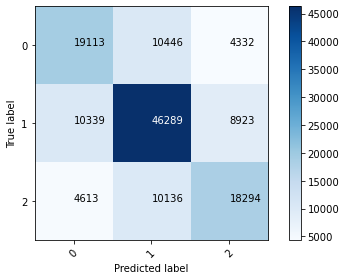

In [23]:
performance(train.Strategy, pred2_train)

              precision    recall  f1-score   support

           0       0.21      0.38      0.27      7173
           1       0.77      0.56      0.65     31106
           2       0.19      0.28      0.23      6630

    accuracy                           0.49     44909
   macro avg       0.39      0.41      0.38     44909
weighted avg       0.60      0.49      0.53     44909



0.2485953934202455

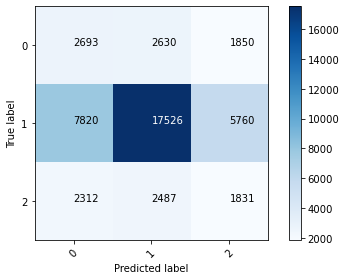

In [24]:
performance(validation.Strategy, pred2)

              precision    recall  f1-score   support

           0       0.22      0.23      0.23      8287
           1       0.66      0.67      0.67     27696
           2       0.21      0.19      0.20      8081

    accuracy                           0.50     44064
   macro avg       0.37      0.37      0.37     44064
weighted avg       0.50      0.50      0.50     44064



0.21366382839465392

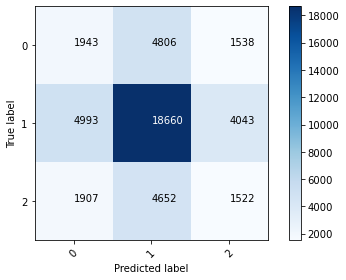

In [25]:
performance(test.Strategy, pred2_test)

# Doc2Vec Model - train a 50-dimensional numeric vector with our own corpus

In [22]:
train.News

0         update confirms putnam talk say deal yet samsu...
1         negroponte add weight diplomacy japan toshiba ...
2         foreign broker place net japan stock sell orde...
3         new chief speed plan reshape bureaucracy updat...
4         longs drug store december us sale pct liberty ...
                                ...                        
132480    royal dutch shell plc interim dividend timetab...
132481    elusive greek deal update watch thursday nov s...
132482    turkey sabanci revenue grow pct hong kong shar...
132483    drop indian national rating criterion bank hyb...
132484    spanish bad bank face struggle lure property i...
Name: News, Length: 132485, dtype: object

In [ ]:
tokenized_doc = []
count = 0
for d in train.News:
    tokenized_doc.append(word_tokenize(d))
    count = count +1
    if count % 10000 == 0:
        print("finished tokenizing the", count, "-th row")

In [29]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

## Use PVDM algo

In [34]:
vector_size = 50
epochs = 30 # in the published "Paragraph Vector" paper results, using 10s-of-thousands to millions of docs, are 10-20.
min_count = 2 # to discard words with very few occurrences

model = Doc2Vec(vector_size = vector_size, 
                min_count = min_count, 
                dm = 1,
                workers=-1)
model.build_vocab(tagged_data)

for epoch in range(epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples = model.corpus_count,
                epochs = model.iter,)
model.save("doc2vec_PVDM.model")

iteration 0
iteration 1


<ipython-input-34-db9abdc66bfd>:15: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  epochs = model.iter,)


iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29


## convert text into numerical vector

In [20]:
# model = Doc2Vec.load("doc2vec_PVDM.model")

In [21]:
train_d2v = d2v(train, model)

finished word tokenization
finished vector representation


In [22]:
test_d2v = d2v(test, model)
validation_d2v = d2v(validation, model)

finished word tokenization
finished vector representation
finished word tokenization
finished vector representation


In [24]:
train_d2v.to_csv("doc2vec_PVDM_train.csv")
test_d2v.to_csv("doc2vec_PVDM_test.csv")
validation_d2v.to_csv("doc2vec_PVDM_validation.csv")

# doc2vec (PVDM) LightGBM

In [20]:
# train_d2v = pd.read_csv("doc2vec_PVDM_train.csv")
# test_d2v = pd.read_csv("doc2vec_PVDM_test.csv")
# validation_d2v = pd.read_csv("doc2vec_PVDM_validation.csv")

train_d2v = train_d2v.iloc[:, 1:]
test_d2v = test_d2v.iloc[:, 1:]
validation_d2v = validation_d2v.iloc[:, 1:]

In [21]:
X_train = train_d2v.iloc[:, 4:]
X_validation = validation_d2v.iloc[:, 4:]
X_test = test_d2v.iloc[:, 4:]

In [22]:
mod3 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = 100, max_depth = 9, num_leaves = 2**9+1, 
                        colsample_bytree = 0.9, reg_alpha = 0, reg_lambda = 4)
fit3 = mod3.fit(X_train, train_d2v.Strategy)
pred3_train = fit3.predict(X_train)
pred3 = fit3.predict(X_validation)
pred3_test = fit3.predict(X_test)

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

           0       0.83      0.92      0.87     33891
           1       0.95      0.84      0.89     65551
           2       0.82      0.93      0.87     33043

    accuracy                           0.88    132485
   macro avg       0.87      0.89      0.88    132485
weighted avg       0.89      0.88      0.88    132485



0.8718518061885763

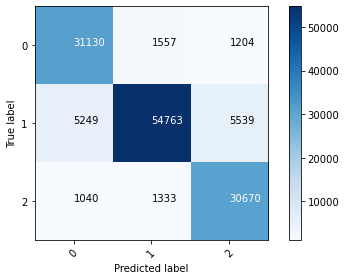

In [23]:
performance(train_d2v.Strategy, pred3_train)

              precision    recall  f1-score   support

           0       0.16      0.27      0.20      7173
           1       0.69      0.47      0.56     31106
           2       0.15      0.27      0.19      6630

    accuracy                           0.40     44909
   macro avg       0.33      0.33      0.32     44909
weighted avg       0.53      0.40      0.45     44909



0.19544976707346834

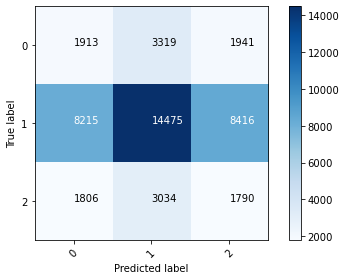

In [24]:
performance(validation_d2v.Strategy, pred3)

              precision    recall  f1-score   support

           0       0.19      0.27      0.22      8287
           1       0.63      0.46      0.54     27696
           2       0.19      0.28      0.22      8081

    accuracy                           0.39     44064
   macro avg       0.34      0.34      0.33     44064
weighted avg       0.47      0.39      0.42     44064



0.22262826061167668

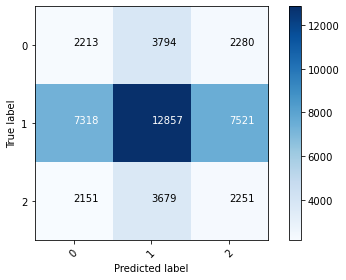

In [25]:
performance(test_d2v.Strategy, pred3_test)

# Hyper parameter turning

In [26]:
n_estimators = [5, 10, 20, 30, 40, 50, 75, 100]
max_depth = [1,2,3,4,5,6,7,8,9]
colsample_bytree = [0.25, 0.5, 0.75, 1]
reg_alpha = [0,1,2,3]
reg_lambda = [0,1,2,3]

In [27]:
val_score = np.zeros((len(n_estimators), len(max_depth), len(colsample_bytree), len(reg_alpha), len(reg_lambda)))

for i in range(len(n_estimators)):
    start_time = time.time()
    
    for j in range(len(max_depth)):
        for k in range(len(colsample_bytree)):
            for l in range(len(reg_alpha)):
                for m in range(len(reg_lambda)):
                    mod3 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", 
                                              random_state = 1234, n_jobs = -1, learning_rate = 0.1, 
                                              n_estimators = n_estimators[i], max_depth = max_depth[j], 
                                              num_leaves = 2**max_depth[j]+1, colsample_bytree = colsample_bytree[k],
                                              reg_alpha = reg_alpha[l], reg_lambda = reg_lambda[m])
                    fit3 = mod3.fit(X_train, train_d2v.Strategy)
                    pred3 = fit3.predict(X_validation)
                    val_score[i,j,k,l,m] = score(validation_d2v.Strategy, pred3)
    
    print("Finished the model with n_estimators =", n_estimators[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with n_estimators = 5
--- 472.63776302337646 seconds ---
Finished the model with n_estimators = 10
--- 541.0460019111633 seconds ---
Finished the model with n_estimators = 20
--- 641.6218400001526 seconds ---
Finished the model with n_estimators = 30
--- 753.4360592365265 seconds ---
Finished the model with n_estimators = 40
--- 873.4469408988953 seconds ---
Finished the model with n_estimators = 50
--- 1006.3063743114471 seconds ---
Finished the model with n_estimators = 75
--- 1286.5362820625305 seconds ---
Finished the model with n_estimators = 100
--- 1587.3980071544647 seconds ---


In [30]:
val_score.max(axis = 4).max(axis = 3).max(axis = 2).max(axis =1)

array([0.21609898, 0.21523279, 0.21568965, 0.21577742, 0.2151491 ,
       0.21678111, 0.21566886, 0.21497374])

In [31]:
val_score.max(axis = 4).max(axis = 3).max(axis = 2).max(axis =0)

array([0.21283964, 0.21458826, 0.21538522, 0.21678111, 0.21545103,
       0.21577742, 0.21609898, 0.21401035, 0.2129342 ])

In [32]:
val_score.max(axis = 4).max(axis = 3).max(axis = 1).max(axis = 0)

array([0.21538522, 0.21609898, 0.21585548, 0.21678111])

In [33]:
val_score.max(axis = 4).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.21609898, 0.21678111, 0.21538522, 0.21536717])

In [34]:
val_score.max(axis = 3).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.21585548, 0.21566886, 0.21577742, 0.21678111])

### By the above gird search, the optimal hyperparameter choice is as follow:

n_estimators = 50

max_depth = 4

colsample_bytree = 1

reg_alpha = 1

reg_lambda = 3

In [44]:
n_estimators = 50
max_depth = 4
colsample_bytree = 1
reg_alpha = 1
reg_lambda = 3

In [45]:
mod3 = lgb.LGBMClassifier(objective = 'multiclass', class_weight = "balanced", random_state = 1234, n_jobs = -1,
                        learning_rate = 0.1, n_estimators = n_estimators, max_depth = max_depth, num_leaves = 2**max_depth+1, 
                        colsample_bytree = colsample_bytree, reg_alpha = reg_alpha, reg_lambda = reg_lambda)
fit3 = mod3.fit(X_train, train_d2v.Strategy)
pred3_train = fit3.predict(X_train)
pred3 = fit3.predict(X_validation)
pred3_test = fit3.predict(X_test)

              precision    recall  f1-score   support

           0       0.34      0.44      0.38     33891
           1       0.59      0.41      0.48     65551
           2       0.33      0.45      0.38     33043

    accuracy                           0.42    132485
   macro avg       0.42      0.43      0.42    132485
weighted avg       0.46      0.42      0.43    132485



0.3826882896182592

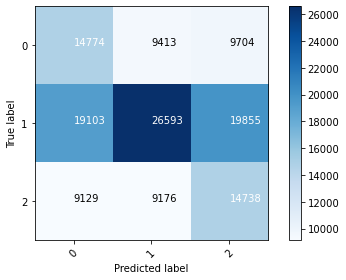

In [46]:
performance(train_d2v.Strategy, pred3_train)

              precision    recall  f1-score   support

           0       0.17      0.33      0.22      7173
           1       0.70      0.34      0.46     31106
           2       0.15      0.35      0.21      6630

    accuracy                           0.34     44909
   macro avg       0.34      0.34      0.30     44909
weighted avg       0.53      0.34      0.38     44909



0.21678111061633004

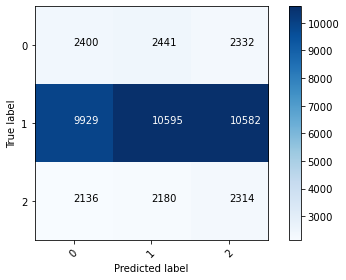

In [47]:
performance(validation_d2v.Strategy, pred3)

              precision    recall  f1-score   support

           0       0.18      0.31      0.23      8287
           1       0.63      0.35      0.45     27696
           2       0.19      0.34      0.24      8081

    accuracy                           0.34     44064
   macro avg       0.33      0.33      0.31     44064
weighted avg       0.46      0.34      0.37     44064



0.2355531392552288

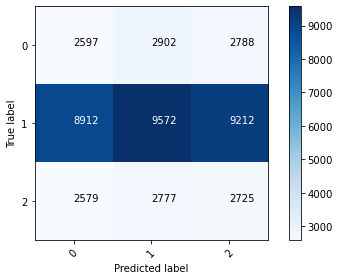

In [48]:
performance(test_d2v.Strategy, pred3_test)

## Apparently, this is not successful. The model now become a random guess even not a weak learner. 
Let's try to use L2 regression as a benchmark to see is it the problem of algorithm choosing

In [51]:
mod4 = RidgeClassifier(alpha = 1.0, normalize=False,tol=0.001, class_weight='balanced', 
                       solver='auto', random_state= 2046)

In [52]:
fit4 = mod4.fit(X_train, train_d2v.Strategy)

pred4_train = fit4.predict(X_train)
pred4 = fit4.predict(X_validation)
pred4_test = fit4.predict(X_test)

              precision    recall  f1-score   support

           0       0.26      0.37      0.31     33891
           1       0.51      0.33      0.40     65551
           2       0.26      0.33      0.29     33043

    accuracy                           0.34    132485
   macro avg       0.34      0.34      0.33    132485
weighted avg       0.38      0.34      0.35    132485



0.2996164551670377

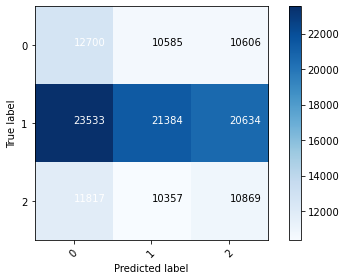

In [54]:
performance(train_d2v.Strategy, pred4_train)

              precision    recall  f1-score   support

           0       0.16      0.37      0.22      7173
           1       0.69      0.32      0.44     31106
           2       0.15      0.31      0.20      6630

    accuracy                           0.33     44909
   macro avg       0.33      0.33      0.29     44909
weighted avg       0.53      0.33      0.37     44909



0.21149348430154635

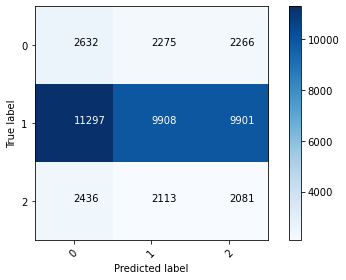

In [55]:
performance(validation_d2v.Strategy, pred4)

              precision    recall  f1-score   support

           0       0.19      0.36      0.25      8287
           1       0.63      0.32      0.42     27696
           2       0.18      0.32      0.23      8081

    accuracy                           0.33     44064
   macro avg       0.33      0.33      0.30     44064
weighted avg       0.46      0.33      0.35     44064



0.2405655297762334

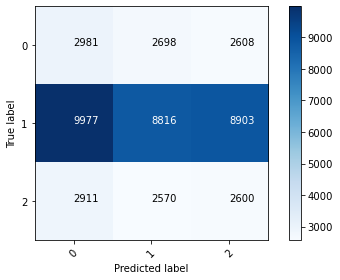

In [56]:
performance(test_d2v.Strategy, pred4_test)

### gird search on Ridge regression

In [61]:
alpha = [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4]

val_score = np.zeros((len(alpha)))

for i in range(len(alpha)):
    start_time = time.time()
    
    mod4 = RidgeClassifier(alpha = alpha[i], normalize=False,tol=0.001, class_weight='balanced', 
                           solver='auto', random_state= 2046)
    fit4 = mod4.fit(X_train, train_d2v.Strategy)
    pred4 = fit4.predict(X_validation)
    val_score[i] = score(validation_d2v.Strategy, pred4)
    
    print("Finished the model with alpha =", alpha[i])
    print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with alpha = 0
--- 0.21952104568481445 seconds ---
Finished the model with alpha = 0.1
--- 0.22603583335876465 seconds ---
Finished the model with alpha = 0.2
--- 0.24279284477233887 seconds ---
Finished the model with alpha = 0.4
--- 0.2246720790863037 seconds ---
Finished the model with alpha = 0.8
--- 0.24910187721252441 seconds ---
Finished the model with alpha = 1.6
--- 0.2554600238800049 seconds ---
Finished the model with alpha = 3.2
--- 0.26706981658935547 seconds ---
Finished the model with alpha = 6.4
--- 0.2945747375488281 seconds ---
Finished the model with alpha = 12.8
--- 0.2622032165527344 seconds ---
Finished the model with alpha = 25.6
--- 0.24501776695251465 seconds ---
Finished the model with alpha = 51.2
--- 0.25139498710632324 seconds ---
Finished the model with alpha = 102.4
--- 0.25452613830566406 seconds ---


In [62]:
val_score

array([0.21159476, 0.21157554, 0.21152278, 0.21150308, 0.2114174 ,
       0.2114701 , 0.21138087, 0.21137745, 0.21149749, 0.21139195,
       0.21143097, 0.21140208])

### L2 regression on doc2vec features as worse as lightGBM using doc2vec features
### Let's make an comparison to using td-idf features.

In [20]:
min_df = [0.01, 0.02, 0.03, 0.04]
max_df = [0.8, 0.85, 0.9, 0.95]
alpha = [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6, 51.2, 102.4]

val_score = np.zeros((len(min_df), len(max_df), len(alpha)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        start_time = time.time()
        basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.News)
        basicvalidation = basicvectorizer.transform(validation.News)
        
        for k in range(len(alpha)):
            mod1 = RidgeClassifier(alpha = alpha[k], normalize=True, class_weight='balanced',
                                   solver='auto', random_state = 4356)
            fit1 = mod1.fit(basictrain, train.Strategy)
            pred1 = fit1.predict(basicvalidation)
            val_score[i,j,k] = score(validation.Strategy, pred1)
            
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])
        print("--- %s seconds ---" % (time.time() - start_time))

Finished the model with min_df = 0.01 and max_df =  0.8
--- 252.8034589290619 seconds ---
Finished the model with min_df = 0.01 and max_df =  0.85
--- 242.27214694023132 seconds ---
Finished the model with min_df = 0.01 and max_df =  0.9
--- 226.44305300712585 seconds ---
Finished the model with min_df = 0.01 and max_df =  0.95
--- 232.31094026565552 seconds ---
Finished the model with min_df = 0.02 and max_df =  0.8
--- 236.8850531578064 seconds ---
Finished the model with min_df = 0.02 and max_df =  0.85
--- 214.15976190567017 seconds ---
Finished the model with min_df = 0.02 and max_df =  0.9
--- 217.46332812309265 seconds ---
Finished the model with min_df = 0.02 and max_df =  0.95
--- 217.05733489990234 seconds ---
Finished the model with min_df = 0.03 and max_df =  0.8
--- 205.51844096183777 seconds ---
Finished the model with min_df = 0.03 and max_df =  0.85
--- 204.83983325958252 seconds ---
Finished the model with min_df = 0.03 and max_df =  0.9
--- 209.94664096832275 seconds 

In [21]:
val_score.max(axis = 2).max(axis = 1)

array([0.2337914 , 0.23316385, 0.23098189, 0.22879664])

In [72]:
val_score.max(axis = 2).max(axis = 1)

array([0.2337914 , 0.23316385, 0.23098189, 0.22879664])

In [73]:
val_score.max(axis = 2).max(axis = 0)

array([0.2337914 , 0.23326414, 0.23368409, 0.23368409])

In [74]:
val_score.max(axis = 1).max(axis = 0)

array([0.21273147, 0.21822481, 0.22050135, 0.22305829, 0.22525303,
       0.22789657, 0.23049397, 0.23193095, 0.23316385, 0.2337914 ,
       0.23112188, 0.22674136])

In [76]:
min_df = 0.01
max_df = 0.8
alpha = 25.6

basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df, max_df = max_df)
basictrain = basicvectorizer.fit_transform(train.News)
basicvalidation = basicvectorizer.transform(validation.News)
basictest = basicvectorizer.transform(test.News)

mod1 = RidgeClassifier(alpha = alpha, normalize=True, class_weight='balanced', solver='auto', random_state = 4356)
fit1 = mod1.fit(basictrain, train.Strategy)

pred1_train = fit1.predict(basictrain)
pred1 = fit1.predict(basicvalidation)
pred1_test = fit1.predict(basictest)

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

           0       0.38      0.26      0.31     33891
           1       0.59      0.63      0.61     65551
           2       0.35      0.42      0.38     33043

    accuracy                           0.48    132485
   macro avg       0.44      0.44      0.43    132485
weighted avg       0.48      0.48      0.48    132485



0.34626483056873747

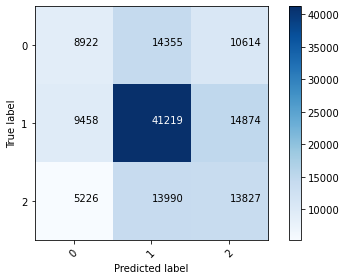

In [77]:
performance(train.Strategy, pred1_train)

              precision    recall  f1-score   support

           0       0.20      0.32      0.25      7173
           1       0.75      0.45      0.56     31106
           2       0.16      0.36      0.22      6630

    accuracy                           0.41     44909
   macro avg       0.37      0.38      0.34     44909
weighted avg       0.58      0.41      0.46     44909



0.23379140473138899

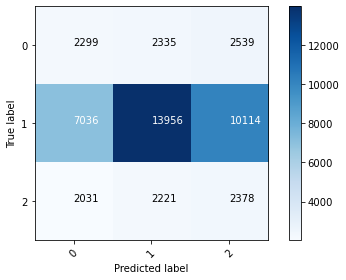

In [78]:
performance(validation.Strategy, pred1)

              precision    recall  f1-score   support

           0       0.22      0.21      0.21      8287
           1       0.65      0.54      0.59     27696
           2       0.18      0.29      0.22      8081

    accuracy                           0.43     44064
   macro avg       0.35      0.35      0.34     44064
weighted avg       0.48      0.43      0.45     44064



0.21828739747778064

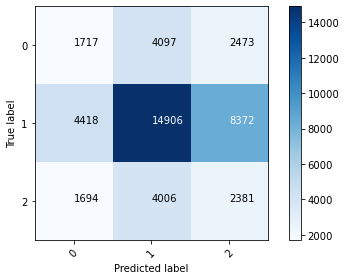

In [79]:
performance(test.Strategy, pred1_test)